### This notebook gets the alignment between the HMM boundaries and the individual boundaries
- It runs the peak alignment and density alignment and finds the ROIs that are shared between the two methods
- It can be run for each movie independently



In [1]:
import warnings
import sys
import os
import glob
import numpy as np
import sys
from statsmodels.stats.multitest import multipletests
from scipy.signal import find_peaks
import random
import copy
from nilearn.surface import vol_to_surf
from nilearn import datasets
fsaverage = datasets.fetch_surf_fsaverage()
from nilearn.plotting import plot_glass_brain, plot_stat_map,  view_img, view_img_on_surf, plot_surf_stat_map, plot_surf_roi, view_surf, plot_surf_contours
from scipy.stats import pearsonr


schaeffer_dir = '/dartfs/rc/lab/F/FinnLab/clara/K99_EventSeg/data/_schaeffer_rois/'
schaeffer_dir_local = '/dartfs/rc/lab/F/FinnLab/clara/K99_EventSeg/data/_schaeffer_rois/_comparisons_no_range_no_train'
schaeffer_save_HMM = '/dartfs/rc/lab/F/FinnLab/clara/K99_EventSeg/data/_schaeffer_rois/_comparisons_no_range_no_train/_HMM_plots/'



/dartfs-hpc/rc/home/9/f004p59/.local/lib/python3.7/site-packages/nilearn/datasets/__init__.py:89: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


# Step 0: Load in the functions and define the movie

In [2]:
mov = 'iteration'

In [3]:
from HMM2Behavioral_alignment_helper_functions import get_peak_locations, plot_locations, clean_peak_loc, match_z, match_loop, color_rois,pvalue_from_null_dist, get_binary_Density,plot_corr_r_filter_p



In [4]:
get_peak_locations

<function HMM2Behavioral_alignment_helper_functions.get_peak_locations(nTRs, results_plot, height=51, behavioral=False)>

# Step 1: Load in the behavioral data
- The data is organized in dictionaries with the subject number as keys

In [5]:
results_gro = np.load('../../data/fig_3_5_behavioral_event_boundaries/behavioral_boundaries/behavioral_boundaries_growth.npy',allow_pickle=True).item()
results_def = np.load('../../data/fig_3_5_behavioral_event_boundaries/behavioral_boundaries/behavioral_boundaries_defeat.npy',allow_pickle=True).item()
results_ite = np.load('../../data/fig_3_5_behavioral_event_boundaries/behavioral_boundaries/behavioral_boundaries_iteration.npy',allow_pickle=True).item()
results_lem = np.load('../../data/fig_3_5_behavioral_event_boundaries/behavioral_boundaries/behavioral_boundaries_lemonade.npy',allow_pickle=True).item()






# Step 2: Density Analysis

747
748
749
747
748
749
750
747
748
749
747
748
749
750
750


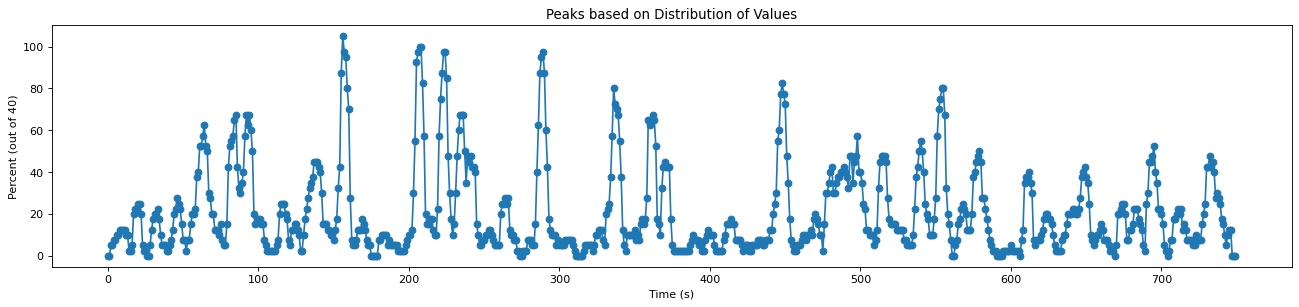

Doing node 1 ... Doing node 2 ... Doing node 3 ... Doing node 4 ... Doing node 5 ... -1
Doing node 6 ... Doing node 7 ... Doing node 8 ... Doing node 9 ... Doing node 10 ... Doing node 11 ... Doing node 12 ... Doing node 13 ... Doing node 14 ... Doing node 15 ... Doing node 16 ... Doing node 17 ... Doing node 18 ... Doing node 19 ... Doing node 20 ... Doing node 21 ... Doing node 22 ... Doing node 23 ... Doing node 24 ... Doing node 25 ... Doing node 26 ... Doing node 27 ... Doing node 28 ... Doing node 29 ... Doing node 30 ... Doing node 31 ... Doing node 32 ... Doing node 33 ... Doing node 34 ... Doing node 35 ... Doing node 36 ... Doing node 37 ... Doing node 38 ... Doing node 39 ... Doing node 40 ... Doing node 41 ... Doing node 42 ... Doing node 43 ... Doing node 44 ... Doing node 45 ... Doing node 46 ... Doing node 47 ... Doing node 48 ... Doing node 49 ... Doing node 50 ... Doing node 51 ... Doing node 52 ... Doing node 53 ... Doing node 54 ... Doing node 55 ... Doing node 56 ..

In [6]:
if mov == 'growth':
    nTRs = 503
    results_plot = copy.deepcopy(results_gro)

elif mov == 'defeat':
    nTRs = 476
    results_plot = copy.deepcopy(results_def)
elif mov == 'iteration':
    nTRs = 746
    results_plot = copy.deepcopy(results_ite)
elif mov == 'lemonade':
    nTRs = 449
    results_plot = copy.deepcopy(results_lem)

counts = {}
for TR in range(nTRs+1):
    counts[TR] = 0

for sub in range(len(results_plot)): 
    #results_plot[sub] = [round(i)+3 for i in results_plot[sub]]
    temp = []
    for i in results_plot[sub]:
        if i < nTRs:
            temp.append(i+ 3)
        else:
            print('WARNING: ISSUE WITH TRS- CHECK')
    results_plot[sub] = temp
    '''ACCOUNTING FOR HRF'''
    
peak_beh = get_binary_Density(nTRs, results_plot, plot=True,behavioral=True)



pval_dict = {}
OG_dict_dens = {}

#this dictionary is available in the data folder - it is set up with movie--> subject--> nodes
bound_dict = np.load('../../data/event_seg/boundary_locations_per_individual.npy',allow_pickle=True).item()

for node in range(1,101): 

    print("Doing node {} ...".format(node), end =" ")
    results_HMM_node = {}

    for sub in range(43):
        results_HMM_node[sub] = bound_dict[mov][f'sub_{sub}'][node]

    peak_node = get_binary_Density(nTRs, results_HMM_node,plot=False)

    null_corr = []
    
    ''' Doing 1000 Random TRs'''
#     for val in range(1000):
#         int_ = random.randint(1,nTRs)
#         peak_node_rand = np.roll(peak_node,int_)

#         null_corr.append(spearmanr(peak_node_rand,peak_beh)[0])

        
    ''' Doing each TR as a perm'''
    for val in range(nTRs):
        peak_node_rand = np.roll(peak_node,val)
        null_corr.append(pearsonr(peak_node_rand,peak_beh[:-4])[0])
        ''' Chopping off the last 3 seconds off behavioral to be the same length as the fMRI'''
    
    OG_med = pearsonr(peak_node,peak_beh[:-4])[0]

    pval_dict[node] = pvalue_from_null_dist(OG_med,np.array(null_corr))
    OG_dict_dens[node] = OG_med
    

In [7]:
pval_list = list(pval_dict.values())
isrsa_mantel_nii,list_of_reg_dens = plot_corr_r_filter_p(OG_dict_dens,pval_list, node_range=range(1,101))


# Step 3: Peak Alignment Method

BEHAVIORAL! Adding 3 TRs to account for HRF
FYI: You are removing below 0s or above the number of TRs, but still accounting for the within TR +-3 Range
The TRs removed are [747, 748, 749, 747, 748, 749, 750, 747, 748, 749, 750, 751, 747, 748, 749, 750, 751, 752, 747, 748, 749, 747, 748, 749] 
. Confirm they are over the number of TRs - 746


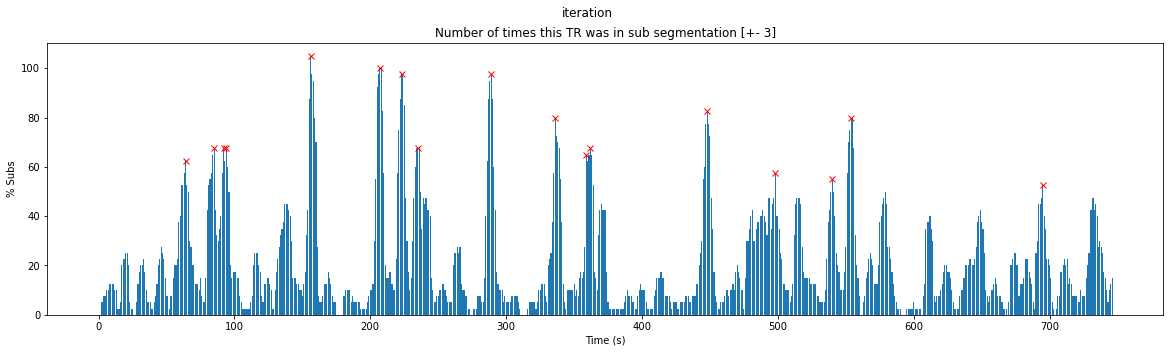

Removing 1 timepoints
peaks_new, middle=True [ 64  85  92  94 156 207 223 235 289 336 362 448 498 540 554 695]
removing peaks that are within 3 TRs


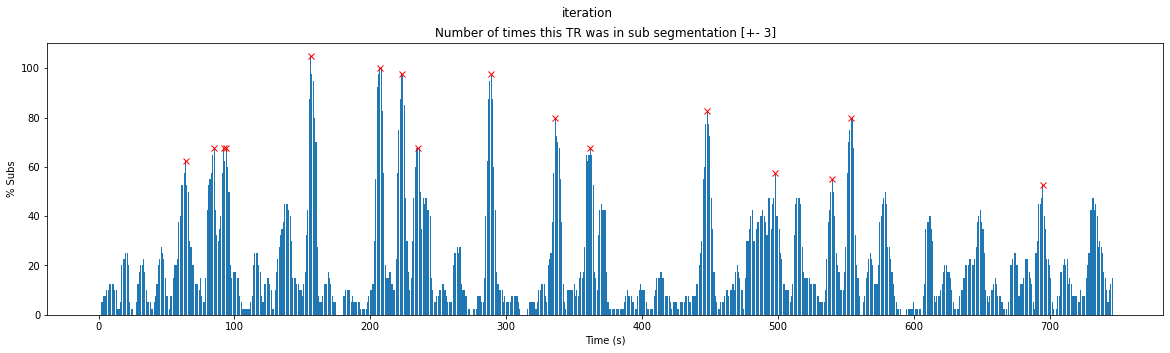

[ 64  85  92  94 156 207 223 235 289 336 359 362 448 498 540 554 695]
[ 64  85  92  94 156 207 223 235 289 336 362 448 498 540 554 695]


In [8]:

if mov == 'growth':
    nTRs = 503
    results_plot = copy.deepcopy(results_gro)
elif mov == 'defeat':
    nTRs = 476
    results_plot = copy.deepcopy(results_def)
elif mov == 'iteration':
    nTRs = 746
    results_plot = copy.deepcopy(results_ite)
elif mov == 'lemonade':
    nTRs = 449
    results_plot = copy.deepcopy(results_lem)
    
''' Getting the Peaks '''
peaks_yielded, counts = get_peak_locations(nTRs,results_plot, height=51, behavioral=True)

''' Plotting these peaks in order to visualize their location and help in decision making on next step'''
plot_locations(mov, nTRs,results_plot,counts, peaks_yielded,height=51)

'''Getting the peaks that are within X TRs of one another'''

range_ = 3
peaks_new = clean_peak_loc(peaks_yielded, counts, range_to_remove=range_,get_middle=False)
print('peaks_new, middle=True',peaks_new)


print(f'removing peaks that are within {range_} TRs')

'''Plotting new peaks'''
plot_locations(mov, nTRs,results_plot,counts,peaks_new,height=51)

print(peaks_yielded)
print(peaks_new)

In [9]:
print(mov)

''' Compare these events to the HMM Nodes'''
gt = 'brain' #'brain'
pval_dict_peak = {}
OG_dict_peak = {}

print("Doing node ...")
bounds_sm = np.load('../../data/fig_3_5_behavioral_event_boundaries/avg_neural_boundaries/avg_sub_event_boundaries_sm_%s_HMM_zscore.npy' %mov, allow_pickle=True).item()

for node in range(1,101): 

    print("{}...".format(node), end =" ")
    results_HMM_node = {}

    if gt=='behavioral':
        p, matchz_mat = match_loop(mov,bounds_sm[node],peaks_new)
    else: #brain as gt 
        p, matchz_mat = match_loop(mov,peaks_new, bounds_sm[node])

    pval_dict_peak[node] = p[0][1]
    OG_dict_peak[node] = matchz_mat[0][1]
print(f'\n Treating the *{gt}* as ground truth')


iteration
Doing node ...
1... 2... 3... 4... 5... 6... 7... 8... 9... 10... 11... 12... 13... 14... 15... 16... 17... 18... 19... 20... 21... 22... 23... 24... 25... 26... 27... 28... 29... 30... 31... 32... 33... 34... 35... 36... 37... 38... 39... 40... 41... 42... 43... 44... 45... 46... 47... 48... 49... 50... 51... 52... 53... 54... 55... 56... 57... 58... 59... 60... 61... 62... 63... 64... 65... 66... 67... 68... 69... 70... 71... 72... 73... 74... 75... 76... 77... 78... 79... 80... 81... 82... 83... 84... 85... 86... 87... 88... 89... 90... 91... 92... 93... 94... 95... 96... 97... 98... 99... 100... 
 Treating the *brain* as ground truth


In [10]:
pval_list_peak = list(pval_dict_peak.values())

isrsa_mantel_nii,list_of_reg_peak = plot_corr_r_filter_p(OG_dict_peak,pval_list_peak, node_range=range(1,101))


# Step 4: Get the ROIs from both methods

In [11]:
to_plot_comb = []
to_plot_comb_onlyz = []
in_both = []
list_ = []
for node in range(100):
    if node in list_of_reg_peak:
        to_plot_comb.append(OG_dict_peak[node+1])
    elif node in list_of_reg_dens:
        to_plot_comb.append(OG_dict_dens[node+1])
    else:
        to_plot_comb.append(np.nan)
    ''' IN BOTH:'''
    if node in list(set(list_of_reg_peak).intersection(list_of_reg_dens)): 
        in_both.append(1)
        to_plot_comb_onlyz.append(OG_dict_peak[node+1])
        list_.append(node)
    else:
        in_both.append(np.nan)
        to_plot_comb_onlyz.append(np.nan)


In [12]:
both_peak_dens = color_rois(to_plot_comb_onlyz)



# Step 5: Plot surface plots of shared locations

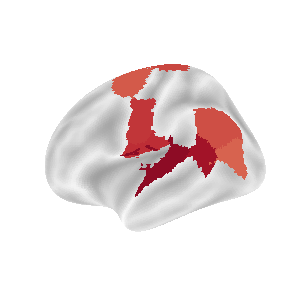

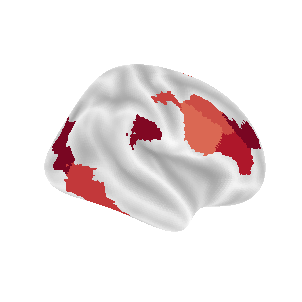

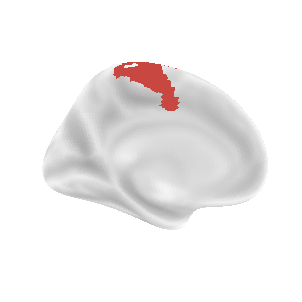

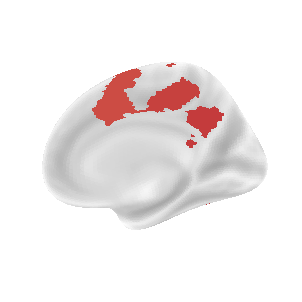

In [13]:
cmap = 'RdBu_r'
vmin = -3
vmax = 3
# fig,ax = plt.subplots(nrows=1, ncols= 2, figsize=(8,8),subplot_kw={'projection': '3d'})

texture = vol_to_surf(both_peak_dens, fsaverage.pial_left,interpolation='nearest',radius =1, n_samples=1)
surf_plot1=plot_surf_roi(fsaverage.infl_left, texture, hemi='left',cmap = cmap, colorbar=False, vmin=vmin,  vmax = vmax,
                             bg_map=fsaverage.sulc_left,darkness=.4)

texture = vol_to_surf(both_peak_dens, fsaverage.pial_right,interpolation='nearest',radius =1, n_samples=1)
surf_plot3=plot_surf_roi(fsaverage.infl_right, texture, hemi='right',cmap = cmap, colorbar=False,vmin=vmin,  vmax = vmax,
                             bg_map=fsaverage.sulc_right,darkness=.4)

texture = vol_to_surf(both_peak_dens, fsaverage.pial_left,interpolation='nearest',radius =1, n_samples=1)
surf_plot2=plot_surf_roi(fsaverage.infl_left, texture, hemi='left',cmap = cmap, colorbar=False,vmin=vmin,  vmax = vmax,
                            bg_map=fsaverage.sulc_left, view = 'medial',darkness=.4)

texture = vol_to_surf(both_peak_dens, fsaverage.pial_right,interpolation='nearest',radius =1, n_samples=1)
surf_plot4=plot_surf_roi(fsaverage.infl_right, texture, hemi='right',cmap = cmap, colorbar=False,vmin=vmin,  vmax = vmax,
                            bg_map=fsaverage.sulc_right, view ='medial',darkness=.4)

